<a href="https://colab.research.google.com/github/CsanyiDavid/deepdream/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install varname

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
from varname import nameof
print(tf.__version__)

2.15.0


Plan
* try inception model
+ create dict of input images and deepdream models and run more experiments
* octave from tf tutorial

# First attempt



In [3]:
imagenet_b_mean = 103.939
imagenet_g_mean = 116.779
imagenet_r_mean = 123.68

In [4]:
def image_properites(img, text=''):
    print(text, type(img), img.shape, img.dtype, np.min(img), np.max(img))

In [5]:
def inverse_preprocess_to_array(image):
    image = np.array(image)
    image[..., 0] += imagenet_b_mean
    image[..., 1] += imagenet_g_mean
    image[..., 2] += imagenet_r_mean
    image = image[..., ::-1] #convert BGR to RGB
    return image

 <class 'numpy.ndarray'> (224, 224, 3) float32 0.0 255.0


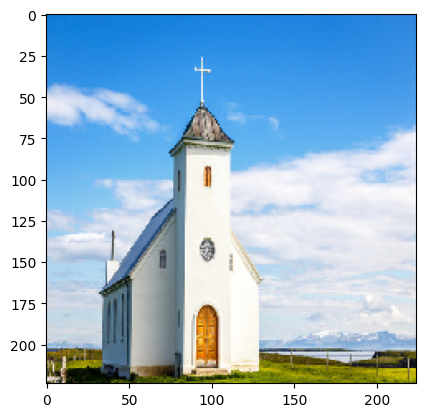

 <class 'numpy.ndarray'> (224, 224, 3) float32 0.0 255.0
 <class 'numpy.ndarray'> (1, 224, 224, 3) float32 -123.68 151.061


In [26]:
#Load and resize image
img_path = 'church.jpg'
img = keras.utils.load_img(img_path, target_size=(224, 224))
x = keras.utils.img_to_array(img)
image_properites(x)

plt.imshow(x/255.)
plt.show()

image_properites(x)
x = np.expand_dims(x, axis=0)
x = keras.applications.vgg19.preprocess_input(x)
image_properites(x)


In [7]:
vgg = keras.applications.VGG19(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

In [8]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [9]:
output = vgg.predict(x)
print(np.max(output), np.argmax(output))
tf.keras.applications.vgg19.decode_predictions(
    output, top=1
)

1/1 [==============================] - 2s 2s/step
0.73197657 947


[[('n07734744', 'mushroom', 0.73197657)]]

 <class 'numpy.ndarray'> (1, 224, 224, 3) int64 0 254


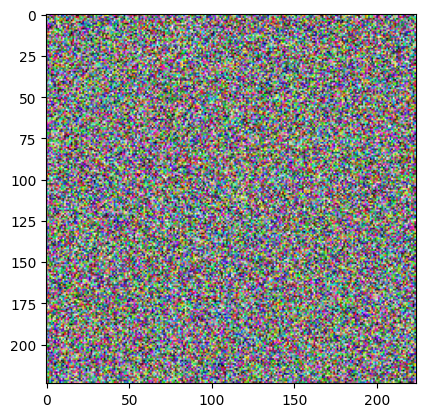

 <class 'numpy.ndarray'> (1, 224, 224, 3) float32 -123.68 150.061


In [10]:
noise = np.random.randint(0, 255, size=(1, 224, 224, 3))
image_properites(noise)
plt.imshow(noise[0])
plt.show()

noise = keras.applications.vgg19.preprocess_input(noise)
image_properites(noise)

In [11]:
output = vgg.predict(noise)
print(np.max(output), np.argmax(output))
tf.keras.applications.vgg19.decode_predictions(
    output, top=1
)

1/1 [==============================] - 1s 723ms/step
0.26738608 611


[[('n03598930', 'jigsaw_puzzle', 0.26738608)]]

In [24]:
deepdream_model = keras.models.Model(
    inputs = [vgg.input],
    #outputs = [vgg.output[:, 152]] #Japanase spaniel
    #outputs = [vgg.output[:, 947]] #mushroom
    #outputs = [vgg.output[:, 113]] #snail
    #outputs = [vgg.output[:, 947],
    #           vgg.output[:, 497],
    #           vgg.output[:, 937]]
    outputs = [vgg.get_layer('fc2').output]
    #outputs = [vgg.get_layer('block5_conv4').output[..., 0:10]]
)

model_description = "VGG19"

In [21]:
def calculate_loss(image, model):
    output = model(image)
    if type(output) != list:
        output = [output]
    output = [tf.math.reduce_mean(i) for i in output]
    return -tf.math.reduce_mean(output)

In [15]:
print(calculate_loss(noise, deepdream_model))
print(calculate_loss(x, deepdream_model))

tf.Tensor(-0.47891378, shape=(), dtype=float32)
tf.Tensor(-0.60571104, shape=(), dtype=float32)


In [16]:
def deepdream(image, model, steps=30, learning_rate=25):
    optimizer = tf.keras.optimizers.Adam(learning_rate)

    dim_expanded = False
    if tf.rank(image) ==3:
        image = tf.expand_dims(image, axis=0)
        dim_expanded = True

    for step in tqdm(range(steps)):
        #print('iteration ', step)
        with tf.GradientTape() as tape:
            tape.watch(image)
            loss = calculate_loss(image, model)

        grad = tape.gradient(loss, image)
        #image_properites(grad, 'grad')
        grad /= tf.math.reduce_max(grad) + 1e-20
        #image_properites(grad, 'scaled grad')
        optimizer.apply_gradients([(grad, image)])
        #image_properites(image, 'input_image')

        img_b, img_g, img_r = tf.split(image, 3, axis=3)
        img_b = tf.clip_by_value(img_b, -imagenet_b_mean, 255.-imagenet_b_mean)
        img_g = tf.clip_by_value(img_g, -imagenet_g_mean, 255.-imagenet_g_mean)
        img_r = tf.clip_by_value(img_r, -imagenet_r_mean, 255.-imagenet_r_mean)
        image.assign(tf.concat([img_b, img_g, img_r], axis=3))

        #image_properites(image, 'after clip by value')

        #print('\n')

    if dim_expanded:
        image = image[0]
    return image

In [17]:
def run_experiment(np_image, image_description, model, model_description, steps=30, learning_rate=5):
    input_image = tf.Variable(np_image)
    result_image = deepdream(input_image, model, steps, learning_rate)

    deprocessed_image = inverse_preprocess_to_array(result_image)
    plt.title("{}, image: {}, steps={}, lr={}".format(model_description,
            image_description, steps, learning_rate))
    plt.imshow(deprocessed_image[0]/255.)
    plt.show()

    return deprocessed_image

100%|██████████| 10/10 [00:40<00:00,  4.05s/it]


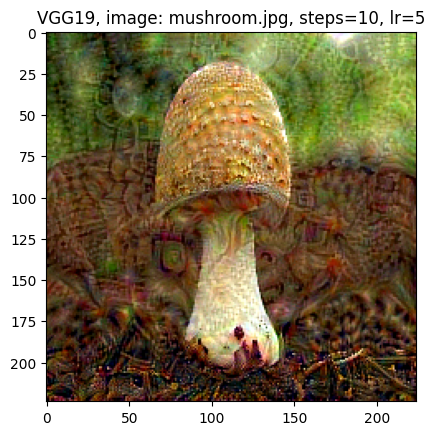

In [25]:
_ = run_experiment(x, img_path, deepdream_model, model_description, steps=10, learning_rate=5)

100%|██████████| 10/10 [00:33<00:00,  3.35s/it]


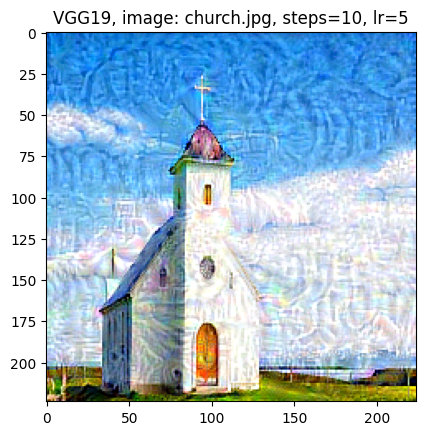

In [27]:
_ = run_experiment(x, img_path, deepdream_model, model_description, steps=10, learning_rate=5)

# Octave